## Beta selection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import jmstate
from jmstate import MultiStateJointModel

In [2]:
torch.manual_seed(0)
sigmoid = torch.jit.script(jmstate.functions.sigmoid)

@torch.jit.script
def f(gamma, x, b):
    psi = gamma + b
    psi[:, 1].exp_()
    return psi

In [3]:
lmda, k = 6, 2
p = 2000
gamma = torch.tensor([4.0, 0.5, 6.0])
Q = torch.diag(torch.tensor([1.0, 0.1, 1.0]))
Q_dist = torch.distributions.MultivariateNormal(torch.zeros(3), Q)
R = torch.tensor([[1.1]])
R_dist = torch.distributions.MultivariateNormal(torch.zeros(1), R)
Q_chol = torch.linalg.cholesky(Q)
R_chol = torch.linalg.cholesky(R)

alphas = {(0, 1): torch.tensor([.4])}
betas = {(0, 1): torch.zeros(p)}
betas[(0, 1)][:4] = torch.tensor([2, -3, 1.7, 3])

real_params = jmstate.types.ModelParams(
    gamma,
    (jmstate.utils.flat_from_cov(Q, method="diag"), "diag"),
    (jmstate.utils.flat_from_cov(R, method="ball"), "ball"),
    alphas,
    betas
)

In [4]:
weibull_fn = jmstate.functions.weibull(k, lmda)
surv = {(0, 1): (weibull_fn, sigmoid)}
model_design = jmstate.types.ModelDesign(f, sigmoid, surv)
real_model = MultiStateJointModel(model_design, real_params)

n = 500
t = torch.linspace(0, 15, 15)
c = torch.rand(n) * 5 + 10
x = torch.randn(n, p)

b = Q_dist.sample((n,))
psi = f(gamma, x, b)

trajectories_init = [[(0.0, 0)] for _ in range(n)]
sample_data = jmstate.types.SampleData(x, trajectories_init, psi)
trajectories = real_model.sample_trajectories(sample_data, c)


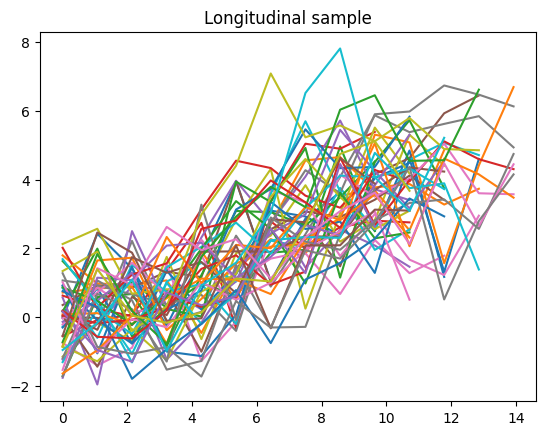

In [5]:
y = model_design.regression_fn(t, psi)
y += R_dist.sample(y.shape[:2])
y[t.repeat(n, 1) > c.view(-1, 1)] = torch.nan

plt.plot(t, y[:50].squeeze(-1).T)
plt.title("Longitudinal sample")
plt.show()

In [6]:
init_params = jmstate.types.ModelParams(
    torch.zeros_like(gamma),
    (torch.zeros_like(jmstate.utils.flat_from_cov(Q, method="diag")), "diag"),
    (torch.zeros_like(jmstate.utils.flat_from_cov(R, method="ball")), "ball"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

data = jmstate.types.ModelData(x, t, y, trajectories, c)
model = MultiStateJointModel(model_design, init_params)
model.fit(data, n_iter=5000, callbacks=jmstate.callbacks.AdamL1Proximal(0.05)())
print("Fitted parameters:", model.params_.betas[(0, 1)])
print("Nonzero betas:" , torch.where(model.params_.betas[(0, 1)] != 0))


Fitting joint model: 100%|██████████| 5000/5000 [00:45<00:00, 108.81it/s]

Fitted parameters: tensor([0.2081, 0.0021, 0.2703,  ..., 0.0000, 0.0000, 0.0000])
Nonzero betas: (tensor([0, 1, 2, 3]),)
